In [1]:
Base.active_project()

"C:\\Users\\Peikai_Li\\.julia\\environments\\v1.11\\Project.toml"

## Problem 1
(a) Write a new version named dgconvect which incorporates the following improvements:

1. Replace the equidistant node positions in an element by the Chebyshev nodes $s_i = cos(πi/p),
   i = 0, . . . , p,$ scaled and translated to $[0, h]$ and in increasing order.

2. Implement support for arbitrary polynomial degrees p, by computing the mass matrix $Mel$ and
   the stiffness matrix $Kel$ using Gaussian quadrature of degree $2p$. Form the nodal basis functions using Legendre polynomials.

3. The original version plots the solution using straight lines between each nodal value. Improve
   this by evaluating the function (that is, the polynomials in each elements) at a grid with 3p
   equidistant nodes, and draw straight lines between those points.

4. Replace the discrete max-norm in the computation of the error by the continuous L2-norm
   ‖u‖₂ = (∫₀¹ u(x)² dx)¹ᐟ².

(b) Write a function with the syntax `errors, slopes = dgconvect_convergence()` which runs your function `dgconvect` using `p = 1, 2, 4, 8, 16`, `∆t = 2 · 10⁻⁴`, `T = 1`, and number of elements n chosen such that the total number of nodes n · p equals 16, 32, 64, 128, 256. 

Return the corresponding errors in the 5-by-5 array errors, and estimate 5 slopes in the array slopes making sure to exclude points that appear to be affected by rounding errors. Also make a log-log plot of the errors vs. the number of nodes n · p.

Slope for p = 1: -2.3004351612854825
Slope for p = 2: -3.397426199134026
Slope for p = 4: -5.133777219517375
Slope for p = 8: -8.197005147399482
Slope for p = 16: -12.196583703963135
Slope for p=8: -9.16743587538892
Slope for p=16: -14.621880787035728


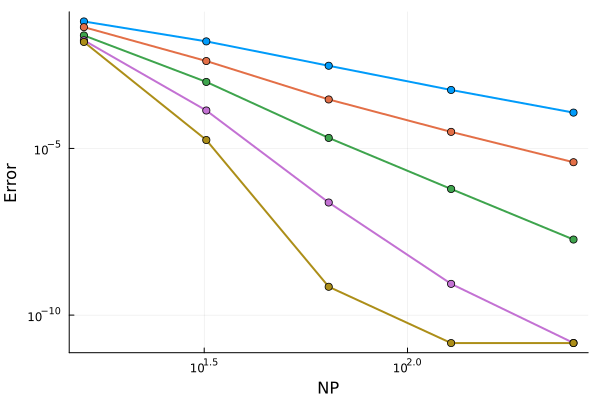

In [1]:
# julia --project="C:\Users\Peikai_Li\.julia\environments\v1.11" q1.jl 

# Reference UC Berkeley Math 228B, Per-Olof Persson <persson@berkeley.edu>
using LinearAlgebra

using Plots
default(legend=false, linewidth=2)
"""
    mkanim(x, allu; [filename, axis])

Utility for animating PDE solutions.
"""
function mkanim(x, allu; filename=tempname() * ".mp4", axis=[0,1,-0.1,1.1])
    anim = @animate for i in 1:length(allu)
        plot(xlims=axis[1:2], ylims=axis[3:4])
        plot!(x[1], allu[i][1], linecolor=:blue, linestyle=:solid)
        plot!(x[2], allu[i][2], linecolor=:black, linestyle=:dash)
    end
    gif(anim, filename)
end



"""
    function gauss_quad(p)

Gaussian quadrature on [-1,1] for given degree of precision `p`
- Gauss–Legendre quadrature is designed for integrals over [-1,1].
- With `n` Gauss–Legendre points, polynomials up to degree `2n-1` 
  are integrated exactly. We choose `n = ceil((p+1)/2)` so that
  `2n-1 ≥ p`.
- We build the symmetric tridiagonal (Jacobi) matrix `J` whose 
  off-diagonal entries are `b_k = k / sqrt(4k^2 - 1)`, k=1..n-1.
- Golub–Welsch:
  * eigenvalues of `J`  → quadrature **nodes** x_i ∈ (-1,1)
  * weights `w_i = 2 * (v[1,i])^2`, where `v[:,i]` is the normalized
    eigenvector corresponding to x_i and `v[1,i]` is its first entry.
- In this code:
  * `eval`  = nodes (x)
  * `2*evec[1,:].^2` = weights (w)
"""
function gauss_quad(p)
    n = ceil((p+1)/2)
    b = 1:n-1
    b = @. b / sqrt(4*b^2 - 1)
    eval, evec = eigen(diagm(1 => b, -1 => b))
    return eval, 2*evec[1,:].^2
end

"""
    legendre_poly(x, p) -> (y, dy)

Evaluate Legendre polynomials and their derivatives at points `x`.

- `y[i,k+1]`  = P_k(x[i])
- `dy[i,k+1]` = P'_k(x[i])

Uses the standard three-term recurrence.
Commonly used in DG/FEM to get basis values and derivatives at quadrature nodes.
"""

function legendre_poly(x, p)
    z = zeros(size(x))
    o = ones(size(x))
    y = hcat(o, x, repeat(z, 1, p-1))
    dy = hcat(z, o, repeat(z, 1, p-1))
    for i = 1:p-1
        @. y[:,i+2] = ((2i+1)*x*y[:,i+1] - i*y[:,i]) / (i+1)
        @. dy[:,i+2] = ((2i+1)*(x*dy[:,i+1] + y[:,i+1]) - i*dy[:,i]) / (i+1)
    end
    y, dy
end

function dgconvect_cheyshev(; n=10, p=1, T=2, dt=1e-3, show_cond = false)
    
    # Discretization
    # n=10;p = 4;T = 1.0
    h = 1 / n
    s = [cos(i*pi/p) for i in p:-1:0]
    x = @. 0.5*h*(s + 1) + (0:h:1-h)' 
    # node s from map [-1,1] to [0,h]+k*h
    # each column corresponds to a different element

    # Gaussian initial condition (and exact solution if shifted)
    uinit(x) = exp(-(x - 0.5)^2 / 0.1^2)

    yy_A,dyy_A = legendre_poly(s, p)
    # phi_A = yy_A^-1 
    # can be the coefficients of the nodal basis functions

    # calculate the M,C matrices
    # M is the mass matrix, C is the stiffness matrix at [-1,1]
    gx, gw = gauss_quad(2p)
    yy_pgx,dyy_pgx = legendre_poly(gx, p)

    # use / yy_A instead of * yy_A^-1 can be more stable but Since I need use  * yy_A^-1 lots of times
    # is this really an good way to do it?
    yy_A = lu(yy_A) # might be better

    phi_Q =  yy_pgx / yy_A  # (yy_pgx * Coeffiecnt  yy_A^-1) 
    dphi_Q = dyy_pgx / yy_A #  / yy_A  is more stable than * yy_A^-1
    M = zeros(p+1, p+1)
    C = zeros(p+1, p+1)
    for i = 1:p+1
        for j = 1:p+1
            for m = 1:length(gw)
                M[i,j] += gw[m] * phi_Q[m,i] * phi_Q[m,j]
                C[i,j] += gw[m] * dphi_Q[m,i] * phi_Q[m,j]
            end
        end
    end
    Mel = M*h/2 # element mass matrix for each element
    # from [-1,1] to [0,h]
    Kel = C
        
    if show_cond == true
        println("Column sums of Kel: ", sum(Kel, dims=1))
        println("cond(Mel) = ", cond(Mel))
        println("eigvals(Mel) = ", eigvals(Mel))
    end

    mel_lu = lu(Mel)


    # RHS function in semi-discrete system
    function rhs(u,it)
        @assert size(u) == (p+1, n)
        @assert !any(isnan.(u)) && !any(isinf.(u))
        r = Kel * u
        r[end,:] = r[end,:] - u[end,:]
        r[1,:] = r[1,:] + u[end, [end; 1:end-1]]
        r = mel_lu \ r
        return r
    end

    # Setup
    u = uinit.(x)
    nsteps = round(Int, T/dt)

    xx_esti01 = -1:2/(3*p):1
    # The interval is [−1,1] The step size is 2/(3p), so the grid will contain about 3p+1 points in total.
    xxx = @. 0.5*h*xx_esti01 + 0.5*h + (0:h:1-h)'
    # xxx = xxx[1:end-1,:][:]
    # push!(xxx, 1) # add the right boundary point

    yy_esti, _ = legendre_poly(xx_esti01, p)
    phi_Value_esti = yy_esti / yy_A # each column is the value of the basis function at xx
    pre_u_xx_esti = phi_Value_esti * u # pre_u_xx is the value of the polynomial at xx

    # Setup plotting
    # xx = (0:0.01:1) # For exact solution
    # allu = [ (u, uinit.(xx)) ]
    allu = [ (pre_u_xx_esti, uinit.(xxx)) ]


    for it = 1:nsteps    
        # Runge-Kutta 4
        k1 = dt * rhs(u,it)
        k2 = dt * rhs(u + k1/2,it)
        k3 = dt * rhs(u + k2/2,it)
        k4 = dt * rhs(u + k3,it)
        u += (k1 + 2*k2 + 2*k3 + k4) / 6

        if any(isnan.(u)) || any(isinf.(u))
            @warn "Solution blew up at step $it"
            return (xxx,xxx), allu, NaN, NaN
        end
            
        pre_u_xx_esti = phi_Value_esti * u # Evaluate the polynomial at xx
        # Plotting
        if mod(it, round(nsteps/100)) == 0 || T < 0.1
            uexact = @. uinit(mod(xxx - dt*it, 1.0))
            push!(allu, (pre_u_xx_esti, uexact))
        end
    end

    uexact = @. uinit(mod(xxx - T, 1.0))  # Exact final solution
    inf_error = maximum(abs.(pre_u_xx_esti - uexact))   # Discrete inf-norm error

    # Compute L2 error using composite trapezoidal rule
    dx = xxx[2] - xxx[1]
    weights = ones(size(xxx)) * dx
    weights[1,:] /= 2
    weights[end,:] /= 2

    # Element-wise square error
    sq_error = (pre_u_xx_esti .- uexact).^2

    # Weighted sum and square root
    l2_error = sqrt(sum(sq_error .* weights))
    return (xxx,xxx), allu, inf_error,l2_error
end
x, allu, inf_error,l2_error = dgconvect_cheyshev(p=3, n=3,T=20)
# mkanim(x, allu, filename="pureconvect_explicit.mp4")


function compute_slope(np_values, errors; tol=1e-10)
    # Filter out errors too small (likely rounding errors)
    keep = errors .> tol
    x = log.(np_values[keep])
    y = log.(errors[keep])

    # Perform simple linear regression: slope of log-log line
    X = [x ones(length(x))]  # [log(NP)  1] matrix
    coeffs = X \ y  # Least squares solution

    return coeffs[1]  # This is the slope
end


function dgconvect_convergence(; dt=2e-4, T=1.0)
    p1 = [1, 2, 4, 8, 16]
    np_values = [16, 32, 64, 128, 256]

    l2_errors = zeros(length(p1), length(np_values))
    for (i, p) in enumerate(p1)
        for (j, np) in enumerate(np_values)
            n = np ÷ p  # Number of elements
            _, _, inf_error, l2_error = dgconvect_cheyshev(p=p, n=n, T=T, dt=dt)
            l2_errors[i,j] = l2_error  # Store L2 error
        end
    end

    slopes = zeros(length(p1))
    for (i, p) in enumerate(p1)
        # Compute slope for each p
        slopes[i] = compute_slope(np_values, l2_errors[i, :])
        println("Slope for p = $p: ", slopes[i])
    end
   
    return l2_errors, slopes
end

l2_errors1, slopes = dgconvect_convergence()

np_values = [16, 32, 64, 128, 256]
slope_p8 = (log(l2_errors1[4,2])- log(l2_errors1[4,3]))/(log.(np_values[2])-log.(np_values[3])) # Check the slope for p=8
slope_p16 = (log(l2_errors1[end,2])- log(l2_errors1[end,3]))/(log.(np_values[2])-log.(np_values[3])) # Check the slope for p=16
println("Slope for p=8: ", slope_p8)
println("Slope for p=16: ", slope_p16)

# Log-log plot with multiple curves
plot(xscale = :log, yscale = :log,
     xlabel = "NP", ylabel = "Error")

for i in 1:5
    plot!(np_values, l2_errors1[i, :],
          marker = :circle, label = "Error i=$i")
end
display(plot!())

### Problem 2(a): 
Write a function with the syntax `u, error = dgconvdiff(; n=10, p=1, T=1.0, dt=1e-3, k=1e-3)` which is a modification of your `dgconvect` function from the previous problem to solve the convection-diffusion equation $$∂u/∂t + ∂u/∂x − k ∂²u/∂x² = 0$$

on x ∈ [0, 1] with the same initial condition as before, $u(x, 0) = e^{−100(x− 0.5)²}$, and
periodic boundary conditions. Use the LDG method for the second-order derivative with C₁₁ = 0
and C₁₂ = 1/2 (pure upwinding/downwinding). For the error computation, use the exact solution

$$u(x, t) = ∑_{i=−N}^{N} 1/√(1 + 400kt) · exp{−100(x− 0.5− t + i)² / (1 + 400kt)}    (2)$$

where N should be infinity but N = 2 is sufficient here.

$$u(x, 0) = e^{−100(x− 0.5)²}$$
$$u_x(x, 0) = −200(x− 0.5)e^{−100(x− 0.5)²}$$

In [ ]:
function u_xt(x, t;k = 1e-3)
    return sum([ 1/(1 + 400*k*t)^(0.5)*exp(−100*(x − 0.5 − t + i)^2 / (1 + 400*k*t)) for i in -2:2])
end


function dgconvdiff(; n=10, p=1, T=1.0, dt=1e-3, k=1e-3, show_cond = false)
    # Discretization
    h = 1 / n
    s = [cos(i*pi/p) for i in p:-1:0]
    x = @. 0.5*h*s + 0.5*h + (0:h:1-h)'


    # Gaussian initial condition (and exact solution if shifted)
    uinit(x) = exp(-(x - 0.5)^2 / 0.1^2)
    uxinit(x) = -200*(x - 0.5)*exp(-(x - 0.5)^2 / 0.1^2)
    u_here(x,t) = u_xt(x, t, k = k)


    yy_A,dyy_A = legendre_poly(s, p)
    yy_A = lu(yy_A) # might be better
    # phi_A = yy_A^-1 # get the basis functions


    # calculate the M,C matrices
    # M is the mass matrix, C is the stiffness matrix
    gx, gw = gauss_quad(2p)
    yy_pgx,dyy_pgx = legendre_poly(gx, p)
    phi_Q = yy_pgx / yy_A
    dphi_Q = dyy_pgx / yy_A
    M = zeros(p+1, p+1)
    C = zeros(p+1, p+1)
    for i = 1:p+1
        for j = 1:p+1
            for m = 1:length(gw)
                M[i,j] += gw[m] * phi_Q[m,i] * phi_Q[m,j]
                C[i,j] += gw[m] * dphi_Q[m,i] * phi_Q[m,j]
            end
        end
    end
    Mel = M*h/2
    Kel = C
        
    if show_cond == true
        println("Column sums of Kel: ", sum(Kel, dims=1))
        println("cond(Mel) = ", cond(Mel))
        println("eigvals(Mel) = ", eigvals(Mel))
    end

    mel_lu = lu(Mel)

    # RHS function in semi-discrete system
    function rhs(u,it)
        @assert size(u) == (p+1, n)
        
        if any(isnan.(u)) || any(isinf.(u))
            @warn "💥 Solution blew up at step $it"
            return NaN * ones(size(u))
        end


        @assert !any(isnan.(u)) && !any(isinf.(u))


        sigma = -Kel * u
        sigma[1,:] = sigma[1,:] - u[1, :] # periodic BC
        sigma[end,:] = sigma[end,:] + u[1,[2:end;1]] # periodic BC
        sigma = mel_lu \ sigma
        
        r = Kel * (u - k*sigma)

        r[1,:] = r[1,:] - (-u[end, [end; 1:end-1]] + k*sigma[end, [end; 1:end-1]])
        r[end,:] = r[end,:] - (u[end,:] - k*sigma[end,:])
        r = mel_lu \ r
        return r
    end

    # Setup
    u = zeros(size(x)[1],size(x)[2],2)
    # Setup
    u[:,:,1] = uinit.(x)
    u[:,:,2] = uxinit.(x)
    nsteps = round(Int, T/dt)

    xx_esti01 = -1:2/(3*p):1
    xxx = @. 0.5*h*xx_esti01 + 0.5*h + (0:h:1-h)'
    
    yy_esti, _ = legendre_poly(xx_esti01, p)
    phi_Value_esti = yy_esti / yy_A # each column is the value of the basis function at xx
    pre_u_xx_esti = phi_Value_esti * u[:,:,1] # pre_u_xx is the value of the polynomial at xx

    # Setup plotting
    allu = [ (pre_u_xx_esti, uinit.(xxx)) ]

    u = u[:,:,1]  # Use only the first component for calculations
    # Main loop
    for it = 1:nsteps    
            # Runge-Kutta 4
            k1 = dt * rhs(u,it)
            k2 = dt * rhs(u + k1/2,it)
            k3 = dt * rhs(u + k2/2,it)
            k4 = dt * rhs(u + k3,it)
            u += (k1 + 2*k2 + 2*k3 + k4) / 6

            if any(isnan.(u)) || any(isinf.(u))
                @warn "💥 Solution blew up at step $it"
                return (xxx,xxx), allu, NaN, NaN
            end
        pre_u_xx_esti = phi_Value_esti * u # Evaluate the polynomial at xx
        # Plotting
        if mod(it, round(nsteps/100)) == 0 || T < 0.1
            uexact = @. u_here(xxx,dt*it)
            push!(allu, (pre_u_xx_esti, uexact))
        end
    end

    uexact = @. u_here(xxx,dt*nsteps)  # Exact final solution
    inf_error = maximum(abs.(pre_u_xx_esti - uexact))   # Discrete inf-norm error


    # Compute L2 error using composite trapezoidal rule
    dx = xxx[2] - xxx[1]
    weights = ones(size(xxx)) * dx
    weights[1,:] /= 2
    weights[end,:] /= 2

    # Element-wise square error
    sq_error = (pre_u_xx_esti .- uexact).^2

    # Weighted sum and square root
    l2_error = sqrt(sum(sq_error .* weights))
    return (xxx,xxx), allu, inf_error,l2_error
end

dgconvdiff (generic function with 1 method)

In [9]:
x, allu, inf_error,l2_error = dgconvdiff(p=2, n=3,show_cond = true)
# mkanim(x, allu,filename="convdiff_explicit.mp4")

Column sums of Kel: [-5.551115123125783e-17 0.0 1.1102230246251565e-16]
Norm of I - yy_A * phi_A: 9.614813431917819e-17
cond(Mel) = 6.879643633704994
eigvals(Mel) = [0.0267919617846787, 0.05555555555555559, 0.18431914932643229]


(([0.0 0.3333333333333333 0.6666666666666666; 0.05555555555555555 0.38888888888888884 0.7222222222222222; … ; 0.2777777777777778 0.6111111111111112 0.9444444444444444; 0.3333333333333333 0.6666666666666666 1.0], [0.0 0.3333333333333333 0.6666666666666666; 0.05555555555555555 0.38888888888888884 0.7222222222222222; … ; 0.2777777777777778 0.6111111111111112 0.9444444444444444; 0.3333333333333333 0.6666666666666666 1.0]), [([1.388794386496407e-11 0.06217652402211632 0.06217652402211643; -0.006900199695561409 0.5831895662320518 0.03455081630992423; … ; 0.034550816309924175 0.5831895662320518 -0.006900199695561418; 0.06217652402211632 0.06217652402211643 1.3887947316454497e-11], [1.388794386496407e-11 0.06217652402211632 0.06217652402211643; 2.6384177944061624e-9 0.29096045886431 0.007166975037612421; … ; 0.007166975037612421 0.29096045886431 2.6384177944061624e-9; 0.06217652402211632 0.06217652402211643 1.388794386496407e-11]), ([0.0018785935051965168 -0.037237044897797916 0.08460855799606

### Problem 2(b)
(b) Write a function with the syntax `errors, slopes = dgconvdiff_convergence()`that performs a convergence study for your dgconvdiff function exactly as in problem 1, using a diffusion coefficient of k = 10⁻³.

Slope for p = 1: -2.341885746698063
Slope for p = 2: -3.440238746633075
Slope for p = 4: -5.268038742669755
Slope for p = 8: -8.61782981194832
Slope for p = 16: -12.36541967733705
Slope for p=16: -15.490409326455323


┌ Warning: 💥 Solution blew up at step 161
└ @ Main In[8]:56
┌ Warning: 💥 Solution blew up at step 161
└ @ Main In[8]:56
┌ Warning: 💥 Solution blew up at step 161
└ @ Main In[8]:105


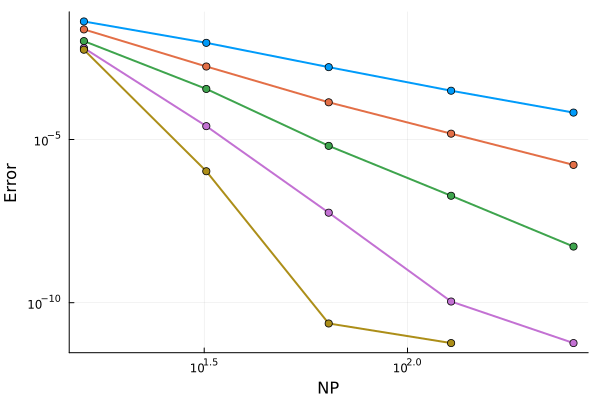

5×5 Matrix{Float64}:
 0.0412034   0.00912548   0.00164234   0.000311542    6.65905e-5
 0.0235171   0.00171768   0.000137574  1.50633e-5     1.66656e-6
 0.0103161   0.000352981  6.37001e-6   1.8874e-7      5.25135e-9
 0.00631355  2.55687e-5   5.71951e-8   1.08719e-10    5.80577e-12
 0.00561282  1.0637e-6    2.31069e-11  5.80295e-12  NaN

In [11]:
function compute_slope(np_values, errors; tol=1e-10)
    # Filter out errors too small (likely rounding errors)
    keep = errors .> tol
    x = log.(np_values[keep])
    y = log.(errors[keep])

    # Perform simple linear regression: slope of log-log line
    X = [x ones(length(x))]  # [log(NP)  1] matrix
    coeffs = X \ y  # Least squares solution

    return coeffs[1]  # This is the slope
end


function dgconvdiff_convergence(; dt=2e-4, T=1.0)
    p1 = [1, 2, 4, 8, 16]
    np_values = [16, 32, 64, 128, 256]

    l2_errors = zeros(length(p1), length(np_values))
    for (i, p) in enumerate(p1)
        for (j, np) in enumerate(np_values)
            n = np ÷ p  # Number of elements
            _, _, inf_error, l2_error = dgconvdiff(p=p, n=n, T=T, dt=dt)
            l2_errors[i,j] = l2_error  # Store L2 error
        end
    end

    slopes = zeros(length(p1))
    for (i, p) in enumerate(p1)
        # Compute slope for each p
        slopes[i] = compute_slope(np_values, l2_errors[i, :])
        println("Slope for p = $p: ", slopes[i])
    end
   
    return l2_errors, slopes
end

l2_errors2, slopes = dgconvdiff_convergence()

np_values = [16, 32, 64, 128, 256]
slope_p16 = (log(l2_errors2[end,2])- log(l2_errors2[end,3]))/(log.(np_values[2])-log.(np_values[3])) # Check the slope for p=4
println("Slope for p=16: ", slope_p16)

# Log-log plot with multiple curves
plot(xscale = :log, yscale = :log,
     xlabel = "NP", ylabel = "Error")

for i in 1:5
    plot!(np_values, l2_errors2[i, :],
          marker = :circle, label = "Error i=$i")
end
display(plot!())

l2_errors2

## let's try to figure out why the last one blow up

In [9]:
x, allu, inf_error,l2_error = dgconvdiff(p=16, n=16,implicit_ = false)

┌ Warning: 💥 Solution blew up at step 65
└ @ Main In[6]:56
┌ Warning: 💥 Solution blew up at step 65
└ @ Main In[6]:108


(([0.0 0.0625 … 0.875 0.9375; 0.0013020833333333322 0.06380208333333333 … 0.8763020833333334 0.9388020833333334; … ; 0.06119791666666667 0.12369791666666667 … 0.9361979166666666 0.9986979166666666; 0.0625 0.125 … 0.9375 1.0], [0.0 0.0625 … 0.875 0.9375; 0.0013020833333333322 0.06380208333333333 … 0.8763020833333334 0.9388020833333334; … ; 0.06119791666666667 0.12369791666666667 … 0.9361979166666666 0.9986979166666666; 0.0625 0.125 … 0.9375 1.0]), [([1.3887943864963355e-11 4.867793902108096e-9 … 7.811489408304514e-7 4.867793902108214e-9; 1.5816598192878063e-11 5.454296171634628e-9 … 7.083512205025257e-7 4.3428855618351e-9; … ; 4.3428855618350755e-9 7.083512205025225e-7 … 5.4542961716346125e-9 1.5816598192877856e-11; 4.8677939021082135e-9 7.811489408304513e-7 … 4.867793902108826e-9 1.3887943864967887e-11], [1.388794386496407e-11 4.867793902108216e-9 … 7.811489408304519e-7 4.867793902108216e-9; 1.5816598192880257e-11 5.454296171634645e-9 … 7.083512205025211e-7 4.3428855618350565e-9; … ; 4

### Construction of the Spatial Operator $\hat{F}$

From the derivation, the semi-discrete DG–LDG system takes the form:

$$
\frac{d\vec{u}}{dt} = \hat{F}(\vec{u}) = F \vec{u},
$$

where the global matrix $F$ is given explicitly as:


$$
\hat{F}(\vec{u}) 
= (I_n \otimes M^{-1})
\left[ I_n \otimes  C(I + \mu M^{-1} C) 
  + D_1
  - D_1 (I_n \otimes M^{-1})(I_n \otimes -C + D_2)
\right]\vec{u}.
$$
- $M, C$ are the local mass and stiffness matrices of size $(p+1) \times (p+1)$;
- $n$ is the number of elements, $I_n$ is the $n \times n$ identity matrix, and the total DOFs are $N = n(p+1)$;

In [2]:
using LinearAlgebra, SparseArrays

"""
    build_F(M, C, n; mu)

Assemble the global spatial operator F such that

    du/dt = F * u

based on LDG discretization with local mass matrix `M` and stiffness matrix `C`.

The operator has the structure:
    A = C ⋅ (I - μ ⋅B) 
    B = (Iₙ ⊗ M⁻¹) ⋅ (Iₙ ⊗ -C + D₂)
    F = (Iₙ ⊗ M⁻¹) ⋅ [ A + D₁ - mu*D₁*B]
where:
- sigma = B*u 
- D₁ and D₂ are periodic interface coupling matrices

# Arguments
- `M::Matrix` : local mass matrix of size (p+1)×(p+1)
- `C::Matrix` : local stiffness matrix of size (p+1)×(p+1)
- `n::Int`    : number of elements
- `mu::Real`  : diffusion term

# Returns
- `F::SparseMatrixCSC{Float64}` : global spatial operator of size N×N, N = n⋅(p+1)
"""
function build_F(Mel::Matrix, C::Matrix, n::Int, mu::Real)    
    p1 = size(Mel, 1)             # local degrees of freedom
    N = n * p1                    # total global DOF    
    Minv = inv(Mel)               # inverse of local mass matrix
    # Initialize global matrices
    D1 = spzeros(N, N)
    D2 = spzeros(N, N)
    # Assemble D1 and D2 based on periodic wraparound
    for k1 in 1:n
        i = k1 * p1
        i2 = (i + 1) % N   # right of i with wrap-around
        # for i = pi*k
        # D1[i, i] = -1, D1[i+1 mod N, i] = +1
        D1[i, i] += -1
        D1[i2, i] += +1
    
        # D2[j, j] = -1
        j = (k1 - 1) * p1 + 1
        j2 = mod(j-1 -1,N)+1
        D2[j, j] += -1
        D2[j2, j] += +1
    end
    
    Mblock = kron(I(n),Minv) # Iₙ⊗M⁻¹ (block-diagonal)
    B = Mblock * (-kron(I(n),C) + D2)  # Iₙ⊗M⁻¹ * Iₙ⊗-C + D2; sigma = B*u 
    A = kron(I(n),C) * (I(N) - mu * B)
    G = (A + D1 - mu*D1*B)
    F = Mblock * G
    
    return B,G,F,D1
end


function anaylize_F(; n=10, p=3, T=1.0, dt=2e-4, k=1e-3,show_cond = true)
    # Discretization
    h = 1 / n
    s = [cos(i*pi/p) for i in p:-1:0]
    x = @. 0.5*h*s + 0.5*h + (0:h:1-h)'

    yy_A,dyy_A = legendre_poly(s, p)
    # phi_A = yy_A^-1 # get the basis functions


    # calculate the M,C matrices
    # M is the mass matrix, C is the stiffness matrix
    gx, gw = gauss_quad(2p)
    yy_pgx,dyy_pgx = legendre_poly(gx, p)
    phi_Q = yy_pgx / yy_A
    dphi_Q = dyy_pgx / yy_A
    M = zeros(p+1, p+1)
    C = zeros(p+1, p+1)
    for i = 1:p+1
        for j = 1:p+1
            for m = 1:length(gw)
                M[i,j] += gw[m] * phi_Q[m,i] * phi_Q[m,j]
                C[i,j] += gw[m] * dphi_Q[m,i] * phi_Q[m,j]
            end
        end
    end
    Mel = M*h/2
    Kel = C
        
    if show_cond == true
        println("Column sums of Kel: ", sum(Kel, dims=1))
        println("cond(Mel) = ", cond(Mel))
        println("eigvals(Mel) = ", eigvals(Mel))
    end

    mel_lu = lu(Mel)

    B,G,F,D1 = build_F(Mel, Kel , n, k)
    B,G,F0,D1 = build_F(Mel, Kel , n, 0)
    return F, F0
end

F, F0 = anaylize_F(; n=16, p=16, T=1.0, dt=2e-4, k=1e-3);
println(size(F))
println("cond(F) = ", cond(F))
println("cond(F0) = ", cond(F0))

Column sums of Kel: [1.3530843112619095e-16 -1.7867651802561113e-16 5.134781488891349e-16 -2.8449465006019636e-16 3.157196726277789e-16 -2.498001805406602e-16 -2.220446049250313e-16 4.0245584642661925e-16 4.0245584642661925e-16 1.6653345369377348e-16 -3.3306690738754696e-16 -3.469446951953614e-16 -1.6653345369377348e-16 2.7755575615628914e-16 -1.1102230246251565e-16 -1.1102230246251565e-16 -1.1102230246251565e-16]
cond(Mel) = 30.284257024323797
eigvals(Mel) = [0.00020164408035406258, 0.0002229021344449231, 0.0012771005688542079, 0.0015384354226829803, 0.002036423195647419, 0.0026386927113233225, 0.0029801533632545256, 0.0036319704639917356, 0.003930596670932708, 0.004492487801958079, 0.004760800778961141, 0.005193153020204308, 0.0054190408389882625, 0.0057109939243270465, 0.005874203398264904, 0.006028793198361118, 0.006106641156875814]
(272, 272)
cond(F) = 2.4515188345441574e17
cond(F0) = 5.521203207582473e16


In [3]:
eigF0 = eigvals(F0)

272-element Vector{ComplexF64}:
     -3570.9078140245438 + 0.0im
      -3534.037193642913 - 390.8166761266813im
      -3534.037193642913 + 390.8166761266813im
     -3426.3095805076346 - 763.2217633210349im
     -3426.3095805076346 + 763.2217633210349im
      -3255.970339261806 - 1100.8160090833044im
      -3255.970339261806 + 1100.8160090833044im
      -3035.482155619232 - 1390.8855147303616im
      -3035.482155619232 + 1390.8855147303616im
     -2779.8635396316085 - 1625.4664681904803im
     -2779.8635396316085 + 1625.4664681904803im
      -2504.821907684763 - 1801.659700197878im
      -2504.821907684763 + 1801.659700197878im
                         ⋮
 -2.3092638912203256e-14 + 62.8318530717958im
 -1.7763568394002505e-14 - 106.81415022205294im
 -1.7763568394002505e-14 + 106.81415022205294im
   4.440892098500626e-15 - 43.98229715025712im
   4.440892098500626e-15 + 43.98229715025712im
   8.881784197001252e-15 - 75.39822368615532im
   8.881784197001252e-15 + 75.39822368615532im
  1.4210

In [4]:
eigF = eigvals(F)

272-element Vector{ComplexF64}:
     -38741.15022618527 + 0.0im
     -38710.83469794743 - 150.20200491575088im
     -38710.83469794743 + 150.20200491575088im
     -38624.32054700199 - 277.99316496195206im
     -38624.32054700199 + 277.99316496195206im
      -38494.3273629858 - 364.12291092860414im
      -38494.3273629858 + 364.12291092860414im
    -38340.171311567436 - 395.30916610721306im
    -38340.171311567436 + 395.30916610721306im
    -38185.096983723866 - 366.34124652797345im
    -38185.096983723866 + 366.34124652797345im
     -38052.88545820267 - 281.1317927640848im
     -38052.88545820267 + 281.1317927640848im
                        ⋮
    -1.4212230337570158 + 37.69911184307777im
    -0.9869604401092618 - 31.415926535898148im
    -0.9869604401092618 + 31.415926535898148im
     -0.631654681670093 - 25.132741228718398im
     -0.631654681670093 + 25.132741228718398im
   -0.35530575843946277 - 18.849555921538595im
   -0.35530575843946277 + 18.849555921538595im
   -0.15791367041758

In [ ]:
# Classical RK4 stability polynomial
rk4_poly(z) = 1 .+ z .+ z.^2/2 .+ z.^3/6 .+ z.^4/24

"""
    dtmax_rk4(lams; safety=0.95, tol=1e-12, iters=60, hi_const=2.9)

Compute the maximum stable time step for RK4 given eigenvalues `lams::AbstractVector{<:Complex}`.
- hi is largest |z| satisfying stability condition
- Returns 0.0 if any eigenvalue has a positive real part (explicit RK4 cannot be stable in that case).
- Uses bisection to find the largest `dt` such that `maximum(abs(R4(dt * λ))) ≤ 1`.
- The upper bound for bisection starts from `hi_const/ρ`, where `ρ = maximum(abs.(lams))`,
  and doubles until the stability condition fails or a maximum number of doublings is reached.

Returns: `dt_max * safety` (a recommended safety factor, default 0.95).
"""
function dtmax_rk4(lams; safety=0.95, tol=1e-12, iters=60, hi_const=2.9)
    # Ensure lams is a vector of complex numbers
    # Any positive real part → unstable for explicit RK4
    if any(real.(lams) .> 0)
        println("Eigenvalue with positive real part detected: explicit RK4 cannot be stable.")
        println("Eigenvalues: ", lams[real.(lams) .> 0])
        if any(real.(lams) .> tol/2)
            return 0.0
        end
    end
    ρ = maximum(abs.(lams))
    ρ == 0 && return Inf  # All zero eigenvalues: arbitrarily stable

    # Initial bisection bounds
    lo = 0.0
    hi = hi_const / ρ
    R(dt) = maximum(abs.(rk4_poly.(dt .* lams)))

    # Expand upper bound until instability or max growth reached
    max_grow = 20
    grow = 0
    while R(hi) <= 1 + tol && grow < max_grow
        hi *= 2
        grow += 1
    end

    # If still stable, return current hi
    if R(hi) <= 1 + tol
        return safety * hi
    end

    # Bisection loop
    for _ in 1:iters
        mid = (lo + hi) / 2
        if R(mid) <= 1 + tol
            lo = mid
        else
            hi = mid
        end
    end
    return safety * lo
end

println("Max stable dt for RK4 with k=0: ", dtmax_rk4(eigF0))
println("Max stable dt for RK4 with diffustion: ", dtmax_rk4(eigF))
cfl = 0.35
advection_time_step = cfl * (1/16) / ((32+1) * 1)
println("Advection time step: ", advection_time_step)
# dt ≈ CFL * h / ((2p+1)|a|)

mu = 1e-3
advection_diffusion_time_step = cfl * (1/16)^2 / (mu * (2*16+1)^2)
println("Advection diffusion time step: ", advection_diffusion_time_step)
# dt ≈ CFL * h / ((2p+1)|a|)
# Courant–Friedrichs–Lewy condition really sucks

# Eigenvalue with positive real part detected: explicit RK4 cannot be stable.
# Eigenvalues: ComplexF64[5.551115123125783e-16 - 6.283185307179545im, 5.551115123125783e-16 + 6.283185307179545im, 7.993605777301127e-15 - 75.39822368615533im, 7.993605777301127e-15 + 75.39822368615533im]
# Max stable dt for RK4 with k=0: 0.0007409961340484654
# Max stable dt for RK4 with diffustion: 6.83002148822931e-5

println("time step check: maximum(abs.(rk4_poly.(2e-4 .* eigF0))) : ", maximum(abs.(rk4_poly.(2e-4 .* eigF0))))
# exist R(0) = 1


println("time step check: maximum(abs.(rk4_poly.(2e-4 .* eigF))) : ", maximum(abs.(rk4_poly.(2e-4 .* eigF))))

println("time step check: maximum(abs.(rk4_poly.(6e-5 .* eigF))) : ", maximum(abs.(rk4_poly.(6e-5 .* eigF))))
println("time step check: maximum(abs.(rk4_poly.(3e-6 .* eigF))) : ", maximum(abs.(rk4_poly.(3e-6 .* eigF)))) 
# exist R(0) = 1

Eigenvalue with positive real part detected: explicit RK4 cannot be stable.
Eigenvalues: ComplexF64[4.440892098500626e-15 - 43.98229715025712im, 4.440892098500626e-15 + 43.98229715025712im, 8.881784197001252e-15 - 75.39822368615532im, 8.881784197001252e-15 + 75.39822368615532im, 1.4210854715202004e-14 - 87.96459430051466im, 1.4210854715202004e-14 + 87.96459430051466im, 1.5987211554602254e-14 - 18.849555921538773im, 1.5987211554602254e-14 + 18.849555921538773im, 3.2852278643288843e-14 + 0.0im]
Max stable dt for RK4 with k=0: 0.0007409961340484665
Max stable dt for RK4 with diffustion: 6.830021488229298e-5
Advection time step: 0.0006628787878787878
Advection diffusion time step: 0.0012554522497704316
time step check: maximum(abs.(rk4_poly.(2e-4 .* eigF0))) : 1.0
time step check: maximum(abs.(rk4_poly.(2e-4 .* eigF))) : 95.91711243278603
time step check: maximum(abs.(rk4_poly.(6e-5 .* eigF))) : 1.0
time step check: maximum(abs.(rk4_poly.(3e-6 .* eigF))) : 1.0


Slope for p = 1: -2.341888388113929
Slope for p = 2: -3.440247836541849
Slope for p = 4: -5.268042954188748
Slope for p = 8: -8.618515496063903
Slope for p = 16: -12.365350844671337
Slope for p=16: -15.538572518337121


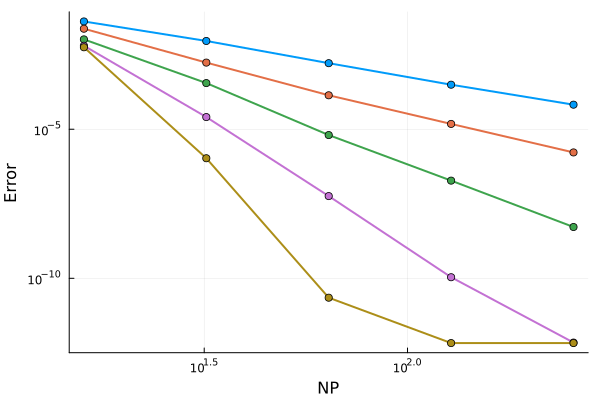

5×5 Matrix{Float64}:
 0.0412034   0.0091255    0.00164234   0.000311542  6.65902e-5
 0.0235175   0.00171768   0.000137573  1.50631e-5   1.66654e-6
 0.0103158   0.000352991  6.36992e-6   1.88737e-7   5.25125e-9
 0.00631335  2.55711e-5   5.71934e-8   1.08548e-10  6.97908e-13
 0.00561257  1.0637e-6    2.23483e-11  6.71649e-13  6.71712e-13

In [49]:
l2_errors2, slopes = dgconvdiff_convergence(dt=6e-5)

np_values = [16, 32, 64, 128, 256]
slope_p16 = (log(l2_errors2[end,2])- log(l2_errors2[end,3]))/(log.(np_values[2])-log.(np_values[3])) # Check the slope for p=4
println("Slope for p=16: ", slope_p16)

# Log-log plot with multiple curves
plot(xscale = :log, yscale = :log,
     xlabel = "NP", ylabel = "Error")

for i in 1:5
    plot!(np_values, l2_errors2[i, :],
          marker = :circle, label = "Error i=$i")
end
display(plot!())

l2_errors2